In [34]:
import pandas as pd
import numpy as np
import sqlite3

# Task 0
Data extraction: get the data from 3 tables & combine it into single `.csv` file.
After that read this file using pandas to create Dataframe.
So it will be all joined data in 1 dataframe. Quick check - should be 74818 rows in it.

In [35]:
connection_db = sqlite3.connect("../db.sqlite3")

In [36]:
sql_query = pd.read_sql_query(
    '''
    SELECT *
    FROM restaurant_orderitem
    INNER JOIN  restaurant_product
    ON restaurant_orderitem.product_id = restaurant_product.id
    INNER JOIN restaurant_order
    ON restaurant_order.id = restaurant_orderitem.order_id
    ''',
    con=connection_db
)

In [37]:
df = pd.DataFrame(sql_query)
df = df.drop(['id', 'order_id', "product_id"], axis=1)
df = df.reindex(columns=["name", "price", 'datetime', 'quantity'])

df

,name,price,datetime,quantity
0,Plain Papadum,0.80,2019-08-03 20:25:00,2
1,King Prawn Balti,12.95,2019-08-03 20:25:00,1
2,Garlic Naan,2.95,2019-08-03 20:25:00,1
3,Mushroom Rice,3.95,2019-08-03 20:25:00,1
4,Paneer Tikka Masala,8.95,2019-08-03 20:25:00,1
...,...,...,...,...
74813,House Red wine 75cl,17.95,2016-05-18 18:53:00,2
74814,House Red wine 75cl,17.95,2016-05-14 19:28:00,2
74815,House Red wine 75cl,17.95,2016-05-10 13:18:00,2
74816,House white wine 75cl,17.95,2016-04-07 19:04:00,1


# Task 1
Get Top 10 most popular products in restaurant sold by Quantity.
Count how many times each product was sold and create a pie chart with percentage of popularity (by quantity) for top 10 of them.

Example:

![pie chart](../demo/pie.png)

name
Plain Papadum           10648
Pilau Rice               6367
Plain Naan               4983
Garlic Naan              3318
Plain Rice               2964
Onion Bhajee             2749
Mango Chutney            2504
Chicken Tikka Masala     2473
Chapati                  1935
Mint Sauce               1840
Name: quantity, dtype: int64

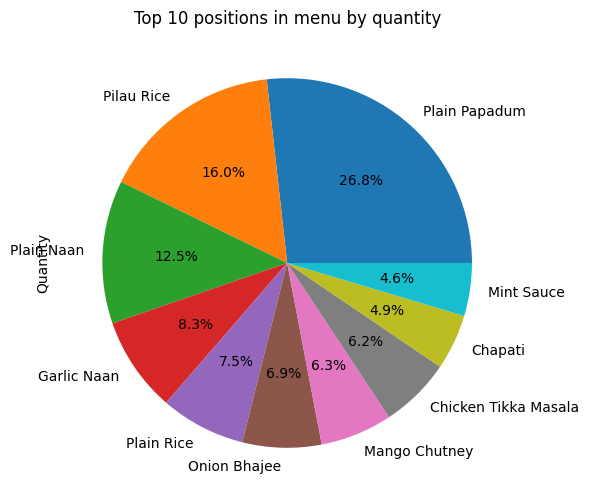

In [38]:
top_10_dishes = df.groupby(by="name")["quantity"].sum().sort_values(ascending=False).head(10)
df["quantity"][df["name"] == "Plain Naan"].sum()
top_10_dishes.plot.pie(
    figsize=(6 ,6),
    autopct='%.1f%%',
    title="Top 10 positions in menu by quantity",
    ylabel="Quantity"
)
top_10_dishes

# Task 2
Calculate `Item Price` (Product Price * Quantity) for each Order Item in dataframe.
And Make the same Top 10 pie chart, but this time by `Item Price`. So this chart should describe not the most popular products by quantity, but which products (top 10) make the most money for restaurant. It should be also with percentage.

<Axes: title={'center': 'Top 10 dishes in menu by revenue'}, ylabel='Profit'>

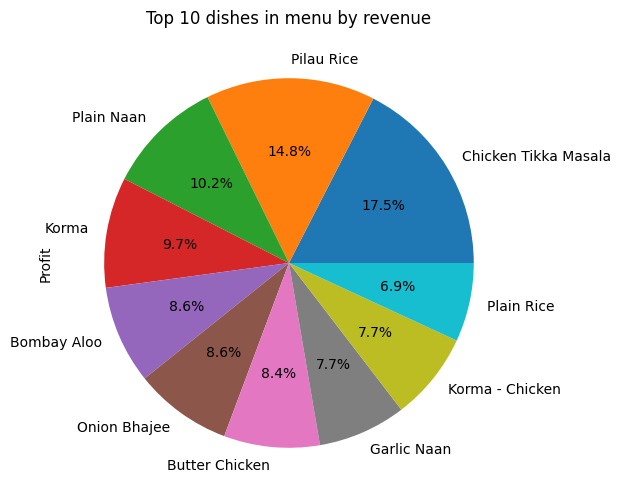

In [39]:
top_10_revenue = df
top_10_revenue["item_price"] = top_10_revenue["price"] * top_10_revenue["quantity"]
top_10_profit = df.groupby("name").sum("item_price").sort_values(by="item_price", ascending=False)[:10]
top_10_profit["item_price"].plot.pie(
    title="Top 10 dishes in menu by revenue",
    figsize=(6,6),
    autopct='%.1f%%',
    ylabel="Profit"
)

# Task 3
Calculate `Order Hour` based on `Order Datetime`, which will tell about the specific our the order was created (from 0 to 23). Using `Order Hour` create a bar chart, which will tell the total restaurant income based on the hour order was created. So on x-axis - it will be values from 0 to 23 (hours), on y-axis - it will be the total sum of order prices, which were sold on that hour.

Example:

![bar chart](../demo/bar.png)

<Axes: title={'center': 'Profit by Order Hour'}, xlabel='Order Hour', ylabel='Profit'>

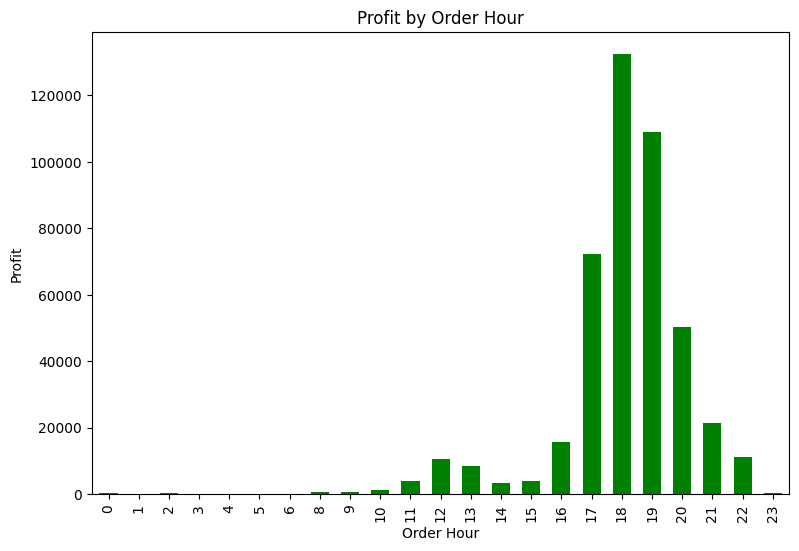

In [56]:
df["datetime"] = pd.to_datetime(df["datetime"])
df["hours"] = df["datetime"].dt.hour
top_hours = df.groupby("hours").sum("item_price").sort_values(by="hours")
top_hours.plot.bar(
    title="Profit by Order Hour",
    y="item_price",
    xlabel="Order Hour",
    ylabel="Profit",
    width=0.6,
    color="g",
    figsize=(9,6),
    legend=False
)

# Task 4
Make similar bar chart, but right now with `Order Day Of The Week` (from Monday to Sunday), and also analyze total restaurant income by each day of the week.

Monday        40008.30
Tuesday       38145.65
Wednesday     41246.20
Thursday      46021.55
Friday       100339.15
Saturday     112191.65
Sunday        67105.95
Name: item_price, dtype: float64

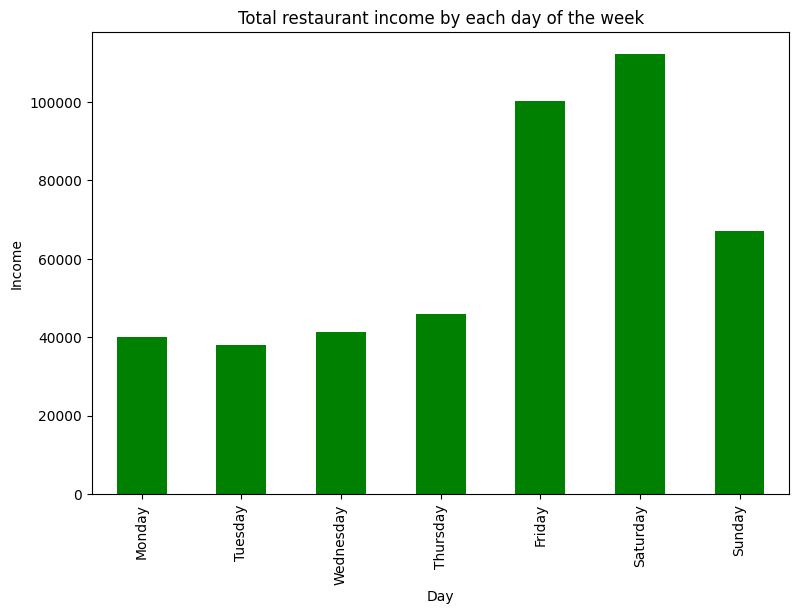

In [60]:
week_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df.groupby(df["datetime"].dt.dayofweek)["item_price"].sum().set_axis(week_days).plot.bar(
    figsize=(9 ,6),
    xlabel="Day",
    ylabel="Income",
    title="Total restaurant income by each day of the week",
    color="g"
)
df.groupby(df["datetime"].dt.dayofweek)["item_price"].sum().set_axis(week_days)